## K-Nearest Neighbors

The purpose of this notebook is to explore using KNN.

In [1]:
import numpy as np
import sys
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import loadmat
import time

%matplotlib inline

First I will use a function to load in matlab data files (given by the course). Using the following function, I will load in the **faces.mat** and **digits.mat** files.

| filename | Description |
| :------- | ----------- |
| faces.mat | contains pictures of people we would like to classify |
| digits.mat | contains numbers that we would like to classify |

In [2]:
def loaddata(filename):
    """
    Returns xTr,yTr,xTe,yTe
    xTr, xTe are in the form nxd
    yTr, yTe are in the form nx1
    """
    data = loadmat(filename)
    xTr = data["xTr"]; # load in Training data
    yTr = np.round(data["yTr"]); # load in Training labels
    xTe = data["xTe"]; # load in Testing data
    yTe = np.round(data["yTe"]); # load in Testing labels
    return xTr.T,yTr.T,xTe.T,yTe.T

The above function takes **filename** as input, and outputs the following variables:

| Variable | Description |
| :------- | ----------- |
| $xTr$ | training features |
| $yTr$ | training labels |
| $xTe$ | test features |
| $yTe$ | test labels |

As the descriptions imply, we want to use $xTr$ and $yTr$ to train our model, and then use $xTe$ and $yTe$ to test it.

### Visualizing the faces data

We will look at 10 training images from the faces dataset and visualize them.

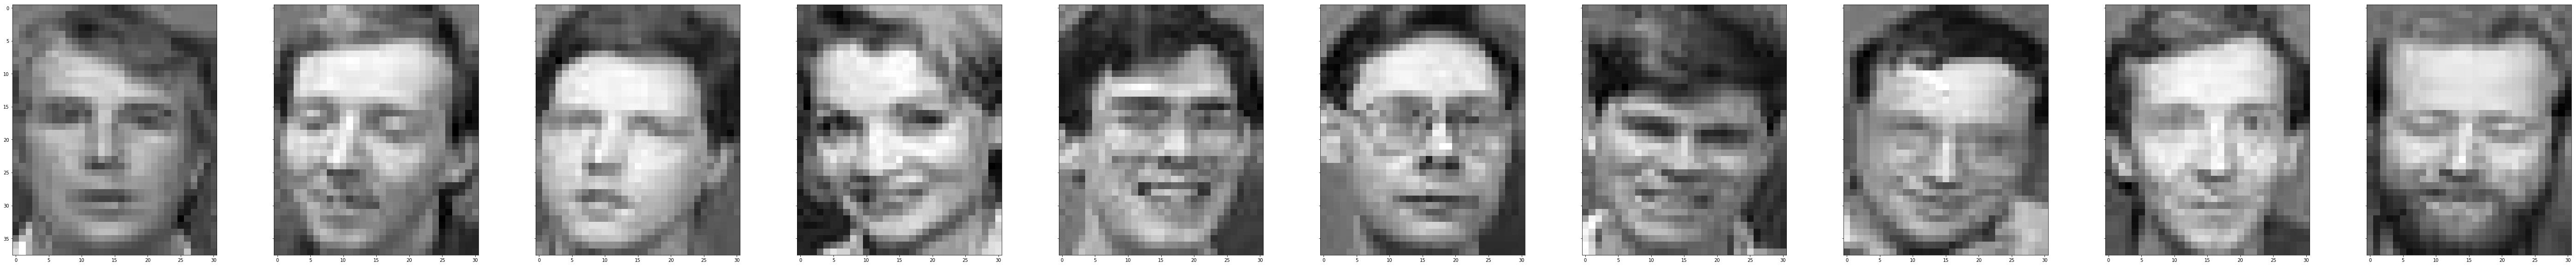

In [3]:
xTr,yTr,xTe,yTe=loaddata("faces.mat")

def plotfaces(X, xdim=38, ydim=31, ):
    n, d = X.shape
    f, axarr = plt.subplots(1, n, sharey=True)
    f.set_figwidth(10 * n)
    f.set_figheight(n)
    
    if n > 1:
        for i in range(n):
            axarr[i].imshow(X[i, :].reshape(ydim, xdim).T, cmap=plt.cm.binary_r)
    else:
        axarr.imshow(X[0, :].reshape(ydim, xdim).T, cmap=plt.cm.binary_r)
plotfaces(xTr[270:280, :])

In [4]:
print(f'The training set contains {yTr.shape[0]} pictures (faces).')
print(f'The test set contains {yTe.shape[0]} pictures (faces).')

print(f'Each picture is made up of {xTr.shape[1]} pixels.')

The training set contains 280 pictures (faces).
The test set contains 120 pictures (faces).
Each picture is made up of 1178 pixels.


Now we need to use the following functions to implement KNN:

1. **l2distance($X$, $Z$)**: Computes the distance between each row of $X$ and each row of $Z$. Can be found in the [euclidean_distance](../euclidean_distance/euclidean_distance.ipynb) notebook.
2. **findknn(xTr, xTe, k)**: finds the $k$ nearest neighbors of a set of vectors within a given training set.

Define the **l2distance** function:

In [5]:
def innerproduct(X, Z=None):
    """
    Computes the inner-product matrix.

    Input:
    X: nxd data matrix with n vectors (rows) of dimensionality d
    Z: mxd data matrix with m vectors (rows) of dimensionality d

    Output:
    Matrix G of size nxm
    G[i,j] is the inner-product between vectors X[i,:] and Z[j,:]

    call with only one input:
    innerproduct(X)=innerproduct(X,X)
    
    Tests:
    >>> M=np.array([[1,2,3],[4,5,6],[7,8,9]])
    >>> Q=np.array([[11,12,13],[14,15,16]])
    >>> print(np.linalg.norm(innerproduct(M,M)-innerproduct(M))<1e-16) # test1: Inner product with itself
    True
    >>> print(np.all(innerproduct(M,Q).T==np.array([[74,182,290],[92,227,362]])))
    True
    """
    if Z is None: 
        Z = X
        
    return np.matmul(X, Z.T)

def l2distance(X,Z=None):
    """  
    Computes the Euclidean distance matrix.
    
    Input:
    X: nxd data matrix with n vectors (rows) of dimensionality d
    Z: mxd data matrix with m vectors (rows) of dimensionality d
    
    Output:
    Matrix D of size nxm
    D(i,j) is the Euclidean distance of X(i,:) and Z(j,:)
    
    call with only one input:
    l2distance(X)=l2distance(X,X)
    """
    if Z is None: 
        Z = X
        
    S = np.array([np.diag(innerproduct(X, X)),]*Z.shape[0]).transpose()
    R = np.array([np.diag(innerproduct(Z, Z)),] * X.shape[0])
    return np.sqrt(S - 2*innerproduct(X,Z) + R)

Now define **findknn**. I want to make an algorithm that first goes through each observation of the test set, and calculates the euclidean distance to each row in the training set. Then, sort the matrix to find the k nearest neighbors in the training set of each observation in the test set. We want to return the indices of the k nearest neighbors, as well as their distances.

In [6]:
def findknn(x_train, x_test, k):
    """
    Finds the k nearest neighbors of x_test in x_train.
    
    Input:
        x_train = nxd input matrix with n row-vectors of dimensionality d
        x_test = mxd input matrix with m row-vectors of dimensionality d
        k = number of nearest neighbors to be found
    
    Output:
        idxs = kxm matrix, where indices(i,j) is the ith nearest neighbor of x_test(j,:)
        dists = Euclidean distances to the respective nearest neighbors
    """
    
    # first calculate D, the matrix that contains the euclidean distance between each row of two different matrices
    D = l2distance(x_train, x_test)
    
    # make idxs: sort D by column and keep the first k rows
    # the jth COLUMN of D represents the jth row of the test set. The ith row in that column
    #      represents the distance between the ith observation in the training set, and the jth
    #      observation in the test set.
    idxs = np.argsort(D, axis=0)[:k,:]
    
    # make dists matrix that return k nearest distances
    dists = np.sort(D, axis=0)[:k,:]
    
    
    
    return idxs, dists

Now, let's use this on our faces dataset to try and identify people by faces

First, let's see if we can find more pictures of the some people in our dataset.

## Visualize **findknn**

Use face labels data to see what the algorithm does

In [8]:
k = 10
indices, dists = findknn(xTr,np.array(xTe, ndmin=2), k)

def plot_test_and_train(xTr, xTe, indices, start=0, stop=5):
    for i, col in enumerate(range(start, stop), start):
        print(f'Test face {i}')
        plotfaces(xTe[col, :].reshape(1,-1))
        plt.show()
        print(f'{indices.shape[0]}-nearest neighbors for test face {i}')
        plotfaces(xTr[indices[:,col], :])
        plt.show()


Test face 9


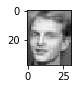

10-nearest neighbors for test face 9


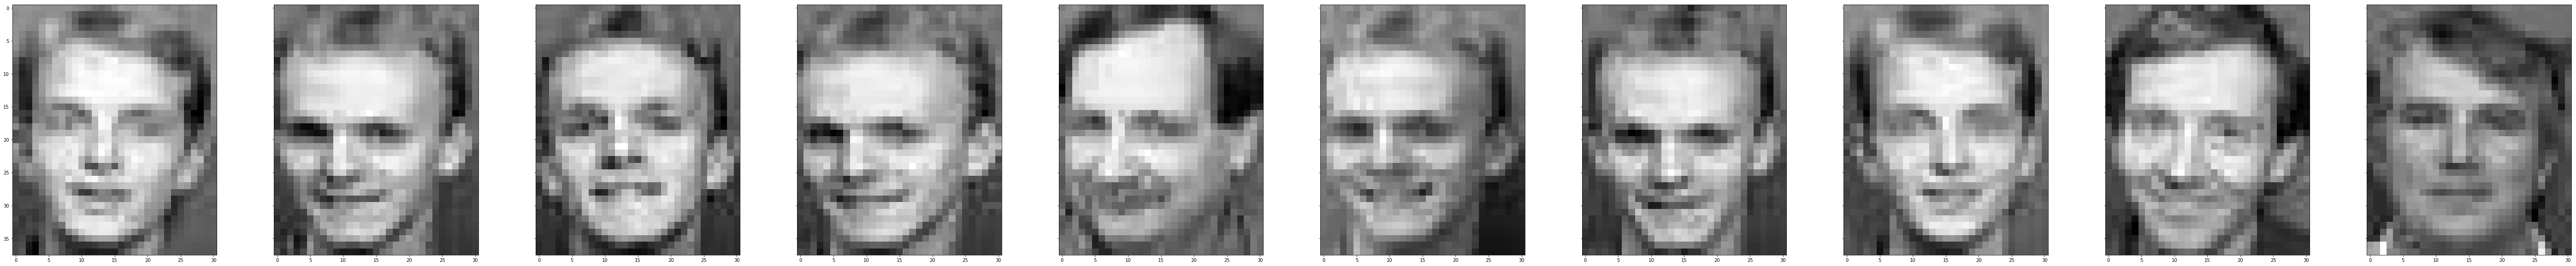

Test face 10


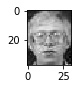

10-nearest neighbors for test face 10


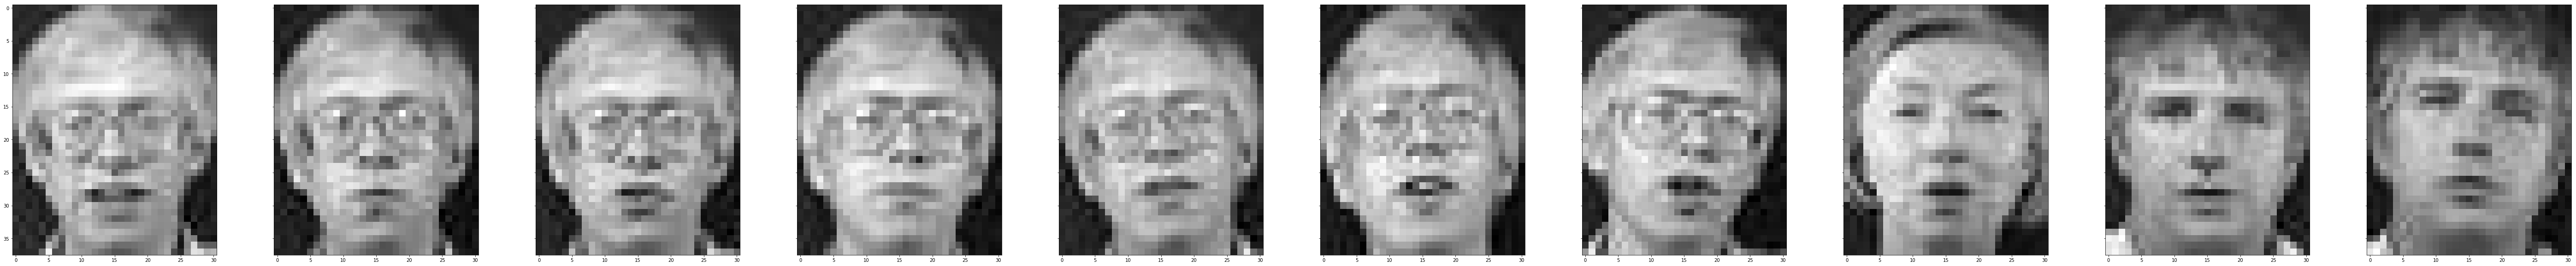

Test face 11


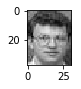

10-nearest neighbors for test face 11


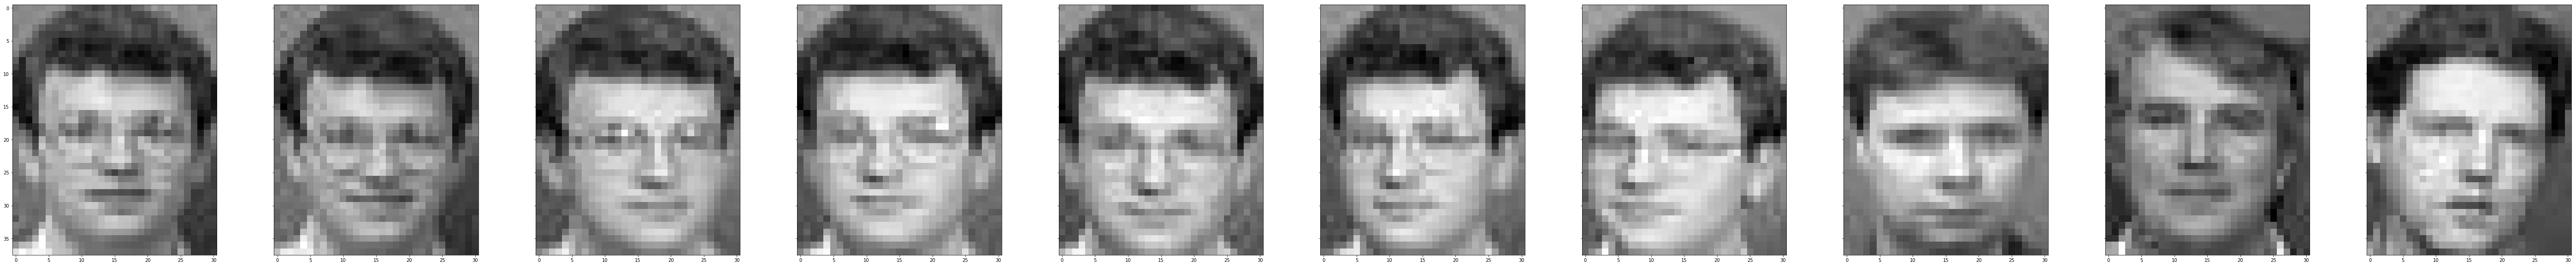

Test face 12


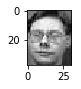

10-nearest neighbors for test face 12


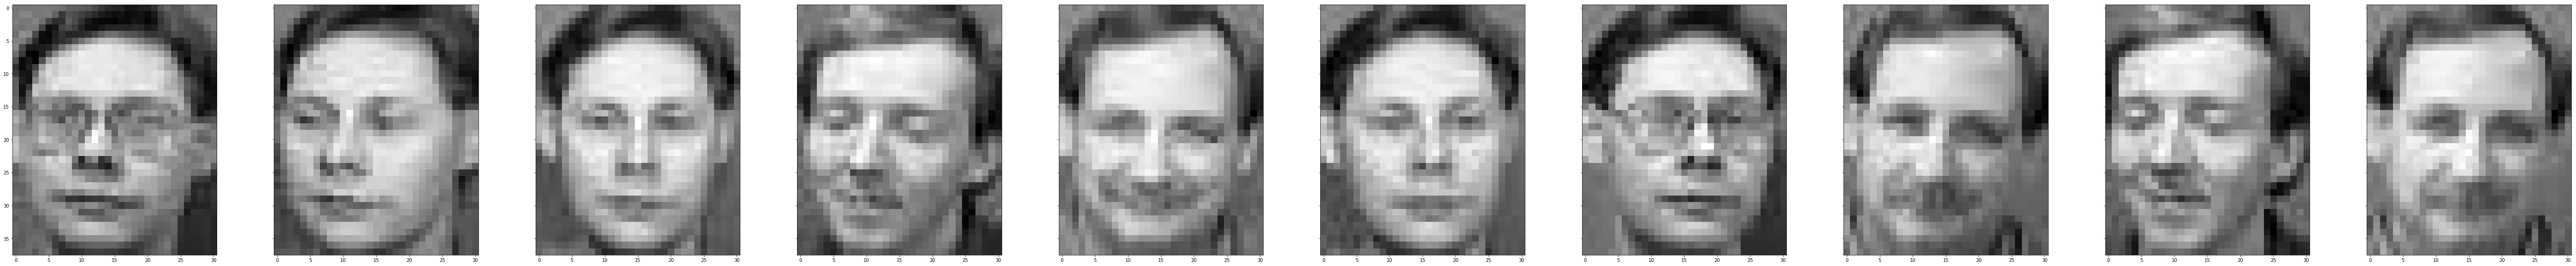

In [9]:
plot_test_and_train(xTr, xTe, indices, 9,13)

## Predict labels

Now the we have found the k nearest neighbors (and have the indices to the corresponding train set), we need to:
1. use the indices to get the training labels
2. use majority voting to predict the class for a given test set observation

In [16]:
from scipy.stats import mode

def knnclassifier(x_train, x_test, y_train, y_test, k):
    """
    Input:
        x_train = nxd input matrix with n row-vectors of dimensionality d
        x_test = mxd input matrix with m row-vectors of dimensionality d
        y_train = nX1 input vector
        y_test = mX1 input vector
        k = number of nearest neighbors to be found
    
    Output:
        predictions = predicted labels for the test set
    """
    indices, dists = findknn(x_train, x_test, k)
    predictions, freq = mode(y_train[indices])
    return predictions.reshape(len(y_test), 1)

predictions = knnclassifier(xTr, xTe, yTr, yTe, k=10)

In [15]:
n = 5
print(f'The first {n} predictions are: ')
predictions[:5]

The first 5 predictions are: 


array([[15],
       [ 3],
       [14],
       [29],
       [ 4]], dtype=uint8)

### Evaluating the Accuracy

In [44]:
def analyze(truth, predictions, kind='acc'):
    """       
    Analyzes the accuracy of a prediction vector with the truth vector
    Input:
        kind = 'acc' classification error
        kind = 'abs' absolute loss
        predictions = mx1 vector of predicted labels
        truth = mx1 vector of actual labels
        (other values of 'kind' will follow later)
    
    Output:
        pct_correct = percent correct
        
    >>> truth = np.array([1,2,3,4,5])
    >>> predictions = np.array([1,5,3,4,6])
    >>> analyze(truth, predictions, kind='acc')
    0.6
    """
    truth = truth.flatten()
    predictions = predictions.flatten()
    
    if kind == 'abs':
        return sum([abs(i - j) for i, j in zip(truth, preds)]) / len(preds)
    elif kind == 'acc':
        return sum(truth == predictions)/len(truth)
    
import doctest
doctest.run_docstring_examples(analyze, globals(), verbose=True)

Finding tests in NoName
Trying:
    truth = np.array([1,2,3,4,5])
Expecting nothing
ok
Trying:
    predictions = np.array([1,5,3,4,6])
Expecting nothing
ok
Trying:
    analyze(truth, predictions, kind='acc')
Expecting:
    0.6
ok


### Hypertuning $k$

In [74]:
import pandas as pd

def knn_ks(xTr, xTe, yTr, yTe, k0=1, kf=25):
    df = pd.DataFrame(columns=['k','accuracy'])
    for k in range(k0,kf+1):
        predictions = knnclassifier(xTr, xTe, yTr, yTe, k)
        acc = analyze(yTe, predictions)
        df = df.append({'k':k,'accuracy':acc}, ignore_index=True)
    return df

knn_ks(xTr, xTe, yTr, yTe, 1,25)

,k,accuracy
0,1.0,0.958333
1,2.0,0.900000
2,3.0,0.908333
3,4.0,0.875000
4,5.0,0.833333
5,6.0,0.850000
6,7.0,0.841667
7,8.0,0.775000
8,9.0,0.758333
9,10.0,0.750000


### Plot k and corresponding accuracies

In [121]:
def plot_acc(xTr, xTe, yTr, yTe, k0, kf, outfile, name):
    df = knn_ks(xTr, xTe, yTr, yTe, k0, kf)
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(df.k, df.accuracy)
    ax = plt.gca()
    ax.set_title(f'K-nearest neighbors classification accuracy for {name}')
    
    ax.set_xlabel('k')
    ax.set_ylabel('accuracy')
    #ax.set_facecolor('xkcd:mint green')
    plt.savefig(outfile,facecolor='#BCBCBCFF')


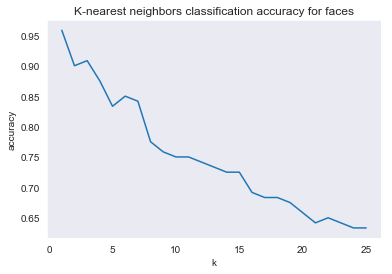

In [122]:
import seaborn as sns
sns.set_style("dark")

xTr,yTr,xTe,yTe=loaddata("faces.mat")
plot_acc(xTr, xTe, yTr, yTe, 1, 25, 'knn_accuracy_faces.png', 'faces')

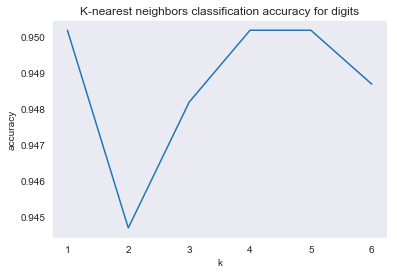

In [118]:
xTr,yTr,xTe,yTe=loaddata("digits.mat")
plot_acc(xTr, xTe, yTr, yTe, 1, 6, 'knn_accuracy_digits.png', 'digits')